In [1]:
print('python')

python


In [2]:
# !pip install -q kaggle timm

In [2]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d sorour/38cloud-cloud-segmentation-in-satellite-images
# !unzip -q /content/38cloud-cloud-segmentation-in-satellite-images.zip -d /content/38-cloud-dataset

The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.
Traceback (most recent call last):
  File "C:\Users\jayga\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\jayga\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\jayga\AppData\Local\Programs\Python\Python310\Scripts\kaggle.exe\__main__.py", line 4, in <module>
  File "C:\Users\jayga\AppData\Local\Programs\Python\Python310\lib\site-packages\kaggle\__init__.py", line 23, in <module>
    api.authenticate()
  File "C:\Users\jayga\AppData\Local\Programs\Python\Python310\lib\site-packages\kaggle\api\kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure i

In [3]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
import torch
import matplotlib.pyplot as plt
import time
import numpy as np

class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True):
        super().__init__()

        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch

    def combine_files(self, r_file: Path, g_dir, b_dir,nir_dir, gt_dir):

        files = {'red': r_file,
                 'green':g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'),
                 'nir': nir_dir/r_file.name.replace('red', 'nir'),
                 'gt': gt_dir/r_file.name.replace('red', 'gt')}

        return files

    def __len__(self):

        return len(self.files)

    def open_as_array(self, idx, invert=False, include_nir=False):

        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)

        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)

        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))

        # normalize
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)


    def open_mask(self, idx, add_dims=False):

        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)

        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask

    def __getitem__(self, idx):

        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.torch.int64)

        return x, y

    def open_as_pil(self, idx):

        arr = 256*self.open_as_array(idx)

        return Image.fromarray(arr.astype(np.uint8), 'RGB')

    def __repr__(self):
        s = 'Dataset class with {} files'.format(self.__len__())

        return s

In [5]:
base_path = Path('./38-cloud-dataset/38-Cloud_training')
data = CloudDataset(base_path/'train_red',
                    base_path/'train_green',
                    base_path/'train_blue',
                    base_path/'train_nir',
                    base_path/'train_gt')
len(data)

8400

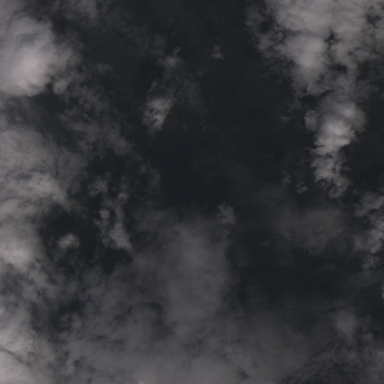

In [13]:
data.open_as_pil(0)

In [19]:
import os

filenames = os.listdir('./38-cloud-dataset/38-Cloud_training/train_green')
print(filenames[0])

# for i in range(8400):
#     img = data.open_as_pil(i)
#     img.save(f'./38-cloud-dataset/38-Cloud_training/png_images/{filenames[i][:-4]}.png')

green_patch_100_5_by_12_LC08_L1TP_061017_20160720_20170223_01_T1.TIF


In [26]:
Image.open(np.array(data[0][1]))

AttributeError: 'numpy.ndarray' object has no attribute 'read'

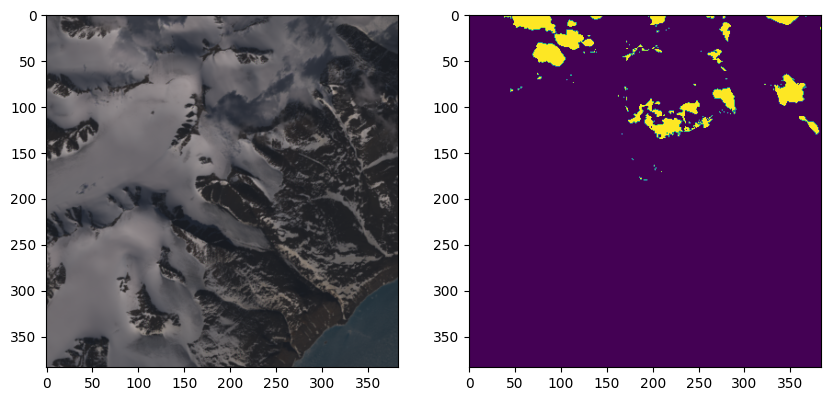

In [27]:
fig, ax = plt.subplots(1,2, figsize=(10,9))
ax[0].imshow(data.open_as_array(630))
ax[1].imshow(data.open_mask(630))